# Mini project assignment for data extraction from shopping website and analysis on it

## Data extraction

### 1) import statements

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import nltk
from nltk import pos_tag, ne_chunk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud


### 2) utils for data extraction and processing

In [2]:
# Function to extract Product Title
def get_title(soup):

    try:
        # Outer Tag Object
        title = soup.find("span", attrs={"class":"B_NuCI"})
        
        # Inner NavigatableString Object
        title_value = title.text

        # Title as a string value
        title_string = title_value.strip()

    except AttributeError:
        title_string = ""

    return title_string

# Function to extract Product Price
def get_price(soup):

    try:
        price = soup.find("div", attrs={"class":"_30jeq3 _16Jk6d"}).string.strip()
        price = re.sub("[^0-9]", "", price)

    except AttributeError:
        price = ""

    return price


# Function to extract Product Rating
def get_rating(soup):

    try:
        rating = soup.find("div", attrs={"class":"_3LWZlK"}).text
    
    except AttributeError:
        rating = ""

    return rating


def get_reviews(soup):
    try:
        emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)
        possible_entities = ("battery", "performance", "display", "ram", "backup", "budget",
                            "rate", "price", "discount", "quality", "processor", "graphic",
                            "money", "power", "range", "keyboard", "gaming", "hdd", "sdd",
                            "value", "core", "build", "touchpad", "memory", "storage", "Upgradability",
                            "boot", "design")
        cumulative_score = 0
        all_review_string = ""
        all_liked_entities = {}
        all_disliked_entities = {}
        
        reviews = soup.find_all("div", attrs={"class":"t-ZTKy"})
        for review in reviews:
            processed_review = emoji_pattern.sub(r'', review.text.split("READ")[0])
            processed_review = processed_review.lower()
            all_review_string += processed_review
            all_review_string += "/**/"
            evaluated_insight = eval_review(processed_review)
#             print(evaluated_insight)
            cumulative_score += evaluated_insight[0]
            
            merged_dict = {key: all_liked_entities.get(key, 0) + evaluated_insight[1].get(key, 0) for key in set(all_liked_entities.keys()).union(evaluated_insight[1].keys())}
            all_liked_entities = merged_dict
            
            merged_dict = {key: all_disliked_entities.get(key, 0) + evaluated_insight[2].get(key, 0) for key in set(all_disliked_entities.keys()).union(evaluated_insight[2].keys())}
            all_disliked_entities = merged_dict
            
            all_liked_entities = dict(sorted(all_liked_entities.items(), key=lambda x: x[1]))
            all_liked_entities = dict(reversed(list(all_liked_entities.items())))
            all_liked_entities = {key: value for key, value in all_liked_entities.items() if key in possible_entities}
            
            all_disliked_entities = dict(sorted(all_disliked_entities.items(), key=lambda x: x[1]))
            all_disliked_entities = dict(reversed(list(all_disliked_entities.items())))
            all_disliked_entities = {key: value for key, value in all_disliked_entities.items() if key in possible_entities}
             
        liked_features = ", ".join(all_liked_entities.keys())
        disliked_features = ", ".join(all_disliked_entities.keys())
        
        if len(reviews) > 0:
            cumulative_score = 10*cumulative_score / len(reviews)
            cumulative_score = round(cumulative_score, 2)
        else:
            cumulative_score = 0
            
    except AttributeError:
        all_review_string = ""
        cumulative_score = 0
        liked_features = ""
        disliked_features = ""
        
    return (all_review_string, cumulative_score, liked_features, disliked_features)



def eval_review(review):
    try:
        sid = SentimentIntensityAnalyzer()
        sub_part = sent_tokenize(review)
#         print(sub_part)
        score = 0
        pos_entity = {}
        neg_entity = {}
        for i in range(0, len(sub_part)):
            sentiment = sid.polarity_scores(sub_part[i])
            score += float(sentiment['compound'])
            entities = find_pos_neg_entities(sub_part[i])
#             print(entities)
            if float(sentiment['compound'] > 0.2):
                for entity in entities:
                    if entity not in pos_entity.keys():
                        pos_entity[entity] = 1
                    else:
                        pos_entity[entity] += 1
            else:
                for entity in entities:
                    if entity not in neg_entity.keys():
                        neg_entity[entity] = 1
                    else:
                        neg_entity[entity] += 1
                
            
        if len(sub_part) > 0:
            score = score/len(sub_part)
        else:
            score = 0
    
    except AttributeError:
        score = 0
        pos_entity = {}
        neg_entity = {}
        
    return (score, pos_entity, neg_entity)
            

    
def find_pos_neg_entities(review_chunk):
    try:
        tagged_reviews = []
        
        words = word_tokenize(review_chunk)
        tagged = pos_tag(words)
        tagged_reviews.append(tagged)

        # Extract important words (nouns and named entities)
        important_words = []
        for tagged_review in tagged_reviews:
            for word, tag in tagged_review:
                if tag in ['NN']:  # NN for singular nouns, NNS for plural nouns
                    important_words.append(word)

        # Remove duplicates
        important_words = list(set(important_words))
    
    except AttributeError:
        important_words = []
    return important_words

### 3) main function to call data extraction utils

In [3]:
if __name__ == '__main__':

    # add your user agent 
    HEADERS = ({'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36', 'Accept-Language':'en-US, en;q=0.5'})

    # The webpage URL
    URL = "https://www.flipkart.com/search?q=gaming+laptop&sid=4rr%2Ctz1&as=on&as-show=on&otracker=AS_QueryStore_OrganicAutoSuggest_1_7_na_na_na&otracker1=AS_QueryStore_OrganicAutoSuggest_1_7_na_na_na&as-pos=1&as-type=RECENT&suggestionId=gaming+laptop%7CGaming+Laptops&requestId=966a2933-1b89-44ca-84d9-c105adef17e3&as-searchtext=gaming%20"

    # HTTP Request
    webpage = requests.get(URL, headers=HEADERS)

    # Soup Object containing all data
    soup = BeautifulSoup(webpage.content, "html.parser")

    # Fetch links as List of Tag Objects
    links = soup.find_all("a", attrs={"class":"_1fQZEK"})

    # Store the links
    links_list = []

    # Loop for extracting links from Tag Objects
    for link in links:
            links_list.append(link.get('href'))

    d = {"title":[], "price":[], "rating":[], "reviews":[], "score":[], "liked":[], "disliked":[]}
    
    # Loop for extracting product details from each link 
    for link in links_list:
        new_webpage = requests.get("https://www.flipkart.com" + link, headers=HEADERS)

        new_soup = BeautifulSoup(new_webpage.content, "html.parser")
        
        # Function calls to display all necessary product information
        d['title'].append(get_title(new_soup))
        d['price'].append(get_price(new_soup))
        d['rating'].append(get_rating(new_soup))
        evaluated_values = get_reviews(new_soup)
#         print(evaluated_values)
        d['reviews'].append(evaluated_values[0])
        d['score'].append(evaluated_values[1])
        d['liked'].append(evaluated_values[2])
        d['disliked'].append(evaluated_values[3])
        

    flipkart_df = pd.DataFrame.from_dict(d)
    flipkart_df.replace('', np.nan, inplace=True)
    flipkart_df.dropna(inplace=True)
    flipkart_df['title'].replace('', np.nan, inplace=True)
    flipkart_df = flipkart_df.dropna(subset=['title'])
    flipkart_df.to_csv("flipkart_data.csv", header=True, index=False)

## EDA

In [8]:
d = pd.DataFrame(d)
d.head(5)

,title,price,rating,reviews,score,liked,disliked
0,Acer Aspire 7 (2023) Core i5 12th Gen 12450H -...,57990,4.2,"other than battery life, this is an absolute b...",4.03,"battery, value, performance, design, gaming, m...","processor, boot, battery, core"
1,MSI Bravo 15 Ryzen 7 Octa Core 5800H - (16 GB/...,61990,4.4,a great product for more than average level ga...,4.62,"range, price, money, budget, performance, batt...","gaming, display, rate, price, battery"
2,MSI Core i7 11th Gen 11800H - (16 GB/512 GB SS...,65990,4.3,best laptop you can get for this budget! it wo...,4.87,"battery, performance, price, backup, gaming, d...","performance, ram"
3,Acer Aspire 7 (2023) Core i5 12th Gen 12450H -...,63990,4.2,i didn't expect the aspire series to give the...,4.88,"performance, display, battery, price, money, r...","display, ram, gaming"
4,ASUS TUF Gaming F15 - AI Powered Gaming Core i...,62190,4.3,"hi all,i have using lenovo gaming laptop for l...",3.65,"price, budget, quality, ram, backup, build, st...","quality, gaming, battery, range, ram, budget, ..."


### 4) Relation between user ratings (rating) and review ratings(score)

[]

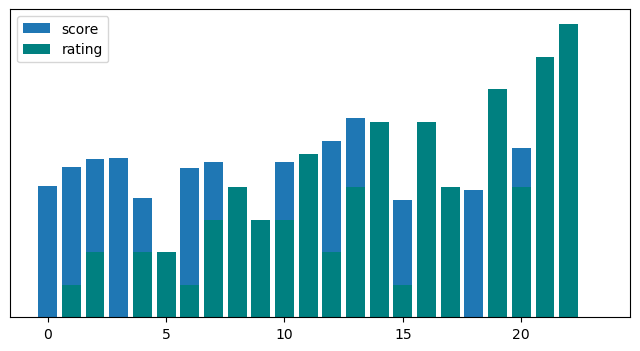

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(d["title"].index, d["score"])
ax.bar(d["title"].index, d["rating"], color="teal")
ax.legend(["score", "rating"])
ax.set_yticks([])

In above plot we can see that:
* There is hardly any relation between our calculated score i.e. "score" and user given ratings
* Due to above point we have to take both of them seperately in consideration while making suggestions

### 5) Generating wordcloud to assess what features people are discussing more in reviews

(-0.5, 599.5, 199.5, -0.5)

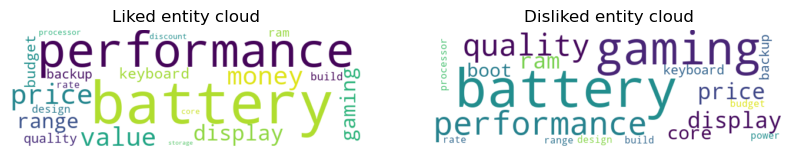

In [10]:
# Combine text from the DataFrame into a single string
text = " ".join(d["liked"])
wordcloud1 = WordCloud(width=600, height=200, background_color='white').generate(text)

text1 = " ".join(d["disliked"])
wordcloud2 = WordCloud(width=600, height=200, background_color='white').generate(text1)

# Create a plot to display the word cloud
plt.figure(figsize=(10, 8))

# plt.imshow(wordcloud1, interpolation="bilinear")

# plt.axis("off")  # Turn off the axis
# plt.title("Word Cloud from liked Column")
# plt.show()
plt.subplot(1, 2, 1)  # 1 row, 3 columns, subplot 1
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Liked entity cloud')
plt.axis('off')

# Create the second subplot (middle)
plt.subplot(1, 2, 2)  # 1 row, 3 columns, subplot 2
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Disliked entity cloud')
plt.axis('off')

* In above shown word clouds we can see that people are discussing about battery, budget, performance, value, etc in their reviews, these can be used for suggestions if any person asks for specific needs

### 6) Let us see which brand has the most products in the site

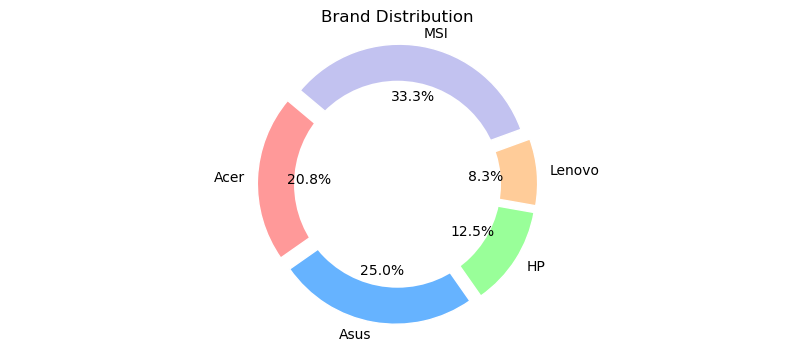

In [11]:
major_laptop_brands = ("Apple", "Acer", "Asus", "Dell", "HP",
                       "Lenovo", "Microsoft", "MSI", "Razer", "Samsung",
                       "Sony", "Toshiba", "LG", "Fujitsu", "Alienware",
                       "Huawei", "Xiaomi", "Google", "VAIO")


brand_counts = {brand: 0 for brand in major_laptop_brands}

# Iterate through the DataFrame and count brand mentions
for description in d["title"]:
    for brand in major_laptop_brands:
        if brand.lower() in description.lower():
            brand_counts[brand] += 1

brand_counts = {key: value for key, value in brand_counts.items() if value > 0}
labels = brand_counts.keys()
frequencies = brand_counts.values()

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

# Calculate the explosion values based on label length
explode = [0.1 * (len(labels) / max(len(label) for label in labels)) for _ in labels]

# Create a figure with two axes: one for the pie chart and one for the hole in the center
fig, ax = plt.subplots(figsize=(10, 4))
ax.pie(frequencies, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
       wedgeprops={'edgecolor': 'white'}, explode=explode)

# Add a circle in the center to create the donut effect
center_circle = plt.Circle((0, 0), 0.80, fc='white')
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Add a title
plt.title("Brand Distribution")

# Display the dynamically exploded donut plot
plt.show()

* This data might help us to comment on aspects like which brand is more diverse when it comes to variety
* This data can be used to suggest user the other variants of same brand as well

### 7) Utils for user querry 

In [12]:
def fetch_best_product(range_):
    result={}
    filtered_df = d[(d['price'].astype(int) >= range_[0]) & (d['price'].astype(int) <= range_[1])]
    filtered_df = filtered_df.sort_values(by='score', ascending=False).astype({'score': float})
    result["name"] = filtered_df.iloc[0].title    
    result["price"] = filtered_df.iloc[0].price
    result["review score"] = filtered_df.iloc[0].score
    result["rating"] = filtered_df.iloc[0].rating
    result["top features"] = filtered_df.iloc[0].liked
    return result

In [13]:
lower = 0
upper = 70000
range_ = (lower, upper)
best_result = fetch_best_product(range_)
print(best_result["name"])

HP Victus Ryzen 5 Hexa Core 5600H - (16 GB/512 GB SSD/Windows 11 Home/4 GB Graphics/NVIDIA GeForce RTX 3050) 15-fb0136AX Gaming Laptop  (15.6 Inch, Performance Blue, 2.37 Kg)
